# CompLabNGS2025 Final Project

## Getting the data
Visit the [Gene Expression Omnibus (GEO) website](https://www.ncbi.nlm.nih.gov/geo/) and search for the accession number you were given. Review the information on the dataset and explore the publication that generated the data.

Write a short but inclusive description of the dataset you were given. Include name of the dataset, the publication, authors, number and condition of samples and any other relevant information to allow others to understand the dataset.

1. extracting info from SRA:

In [1]:
!esearch -db sra -query "SRP349257" | efetch -format runinfo | column -t -s ","

Run          ReleaseDate          LoadDate             spots     bases       spots_with_mates  avgLength  size_MB  AssemblyName  download_path                                                                                                Experiment   LibraryName  LibraryStrategy  LibrarySelection  LibrarySource   LibraryLayout  InsertSize  InsertDev  Platform  Model        SRAStudy   BioProject   Study_Pubmed_id  ProjectID  Sample       BioSample     SampleType  TaxID  ScientificName  SampleName  g1k_pop_code  source  g1k_analysis_group  Subject_ID  Sex  Disease  Tumor  Affection_Status  Analyte_Type  Histological_Type  Body_Site  CenterName        Submission                 dbgap_study_accession  Consent     RunHash  ReadHash                                    
SRR17133387  2024-03-07 21:42:15  2021-12-04 17:46:41  23255124  1162756200  0                 50         632                    https://sra-downloadb.be-md.ncbi.nlm.nih.gov/sos3/sra-pub-zq-22/SRR017/17133/SRR17133387/SRR171333

in more readable format:
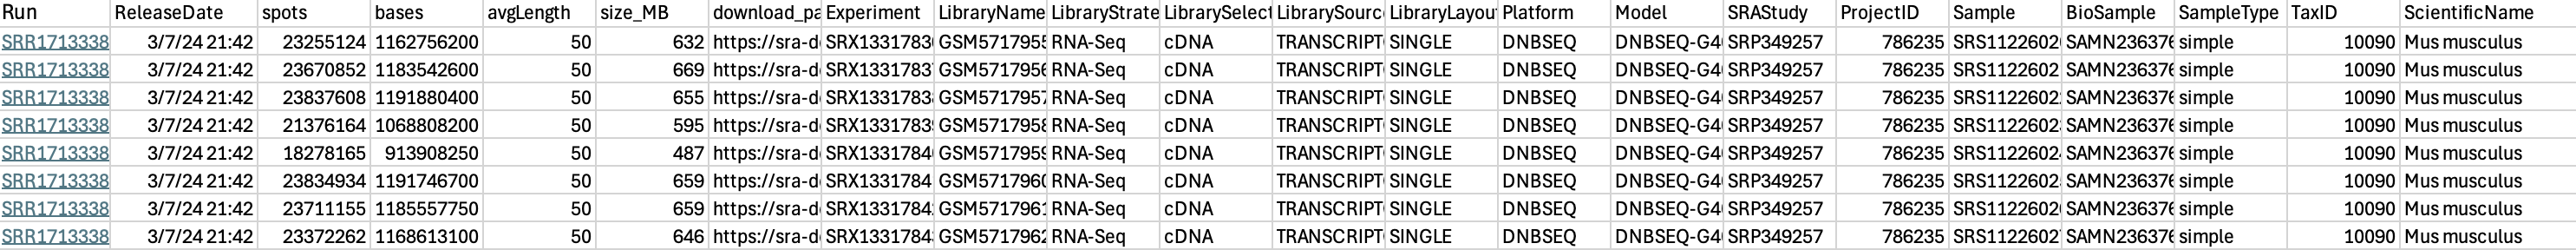

- **Dataset**: [GSE190189](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE190189) – Induction of Immortal-like CAR-T Cells

- **Published**: March 7, 2024

- **Authors**: Wang L., Jin G., Peng M.

- **Organism**: Mus musculus (mouse)

- **Experiment**: Bulk RNA-seq of mouse samples  
- **Experiment type**: Transcriptomic profiling by high throughput sequencing

- **Samples**:
    - SRR17133380: sgZc3h12a-Day10-replicate-1
    - SRR17133381: sgZc3h12a-Day10-replicate-2
    - SRR17133382: CAR19TIF-Day10-replicate-1
    - SRR17133383: CAR19TIF-Day10-replicate-2
    - SRR17133384: CAR19TIF-3mon-replicate-1
    - SRR17133385: CAR19TIF-3mon-replicate-2
    - SRR17133386: Endo CD8-replicate-1
    - SRR17133387: Endo CD8-replicate-2

- **Sequencing layout**: Single-end

- **Sequences per file**: $18 - 24 \times 10^6$

-  **bases per file**: ~1 Gbp

- **Average read length**: 50 bp

- **Sequencer**:  DNBSEQ-G400


After completing the entire analysis, create a conda environment with all the necessary packages and their versions to run the analysis. In the cell below, write the command you used to create the environment and the command to activate it. The name of the environment should be `<first name>_<last name>`. You can use ```bash conda list``` to list all the packages and their versions in the environment.

Modify the example command below to include the packages you used in your analysis.

In [2]:
!conda create -n Arielle_Arabov_Tomer_Oron \
    python=3.10 \
    ipykernel \
    sra-tools=3.2.0 \
    kallisto==0.50.1 \
    numpy=2.2.2 \
    pandas=2.2.3 \
    matplotlib=3.10.0 \
    scipy=1.15.1 \
    scikit-learn=1.6.1 \
    pydeseq2=0.5.0 \
    entrez-direct=22.4 \
    multiqc=1.27 \
    fastqc=0.12.1 \
    trimmomatic=0.39




!conda activate Arielle_Arabov_Tomer_Oron

done

Remove existing environment?
This will remove ALL directories contained within this specified prefix directory, including any other conda environments.

^Cy/[n])? 

CondaSystemExit: 
Operation aborted.  Exiting.


CondaError: Run 'conda init' before 'conda activate'



## Getting the raw fastq files
At the bottom of the GEO page, you will find a link to the `SRA Run Selector`. Click on the link. 

Explain what is the SRA and SRR in gerneal and how it is used to store sequencing data.


**Sequence Read Archive (SRA)**

A publicly accessible database maintained by the NCBI for storing raw high-throughput sequencing data.

**Sequence Read Run (SRR)**

A unique identifier for an individual sequencing run within an SRA study, representing a specific sample or condition.

**Usage:**
- Retrieve raw sequencing reads in FASTQ format.
- Reanalyze data using bioinformatics pipelines.
- Access metadata for reproducibility and interpretation.


In [2]:
# extracting SRR as folders
!prefetch SRP349257 -O SRP349257
# converting into fastqc
!for sra_folder in ./SRP349257/*; do echo "$sra_folder"; fasterq-dump "$sra_folder" -e 4 --outdir SRP349257_fastq; done

2025-02-05T21:13:14 prefetch.3.2.0: 1) Resolving 'SRP349257'...
2025-02-05T21:13:16 prefetch.3.2.0 int: string unexpected while executing query within virtual file system module - multiple response SRR URLs for the same service 's3'
2025-02-05T21:13:16 prefetch.3.2.0 int: string unexpected while executing query within virtual file system module - multiple response SRR URLs for the same service 's3'
2025-02-05T21:13:16 prefetch.3.2.0 int: string unexpected while executing query within virtual file system module - multiple response SRR URLs for the same service 's3'
2025-02-05T21:13:16 prefetch.3.2.0 int: string unexpected while executing query within virtual file system module - multiple response SRR URLs for the same service 's3'
2025-02-05T21:13:16 prefetch.3.2.0 int: string unexpected while executing query within virtual file system module - multiple response SRR URLs for the same service 's3'
2025-02-05T21:13:16 prefetch.3.2.0 int: string unexpected while executing query within virt

Use `prefetch + fasterq-dump` command from the `SRA Toolkit` to download the fastq files. Write the command you used to download the fastq files. [SRA Tools Conda installation](https://anaconda.org/bioconda/sra-tools)

## Quality Control
Below include all the commands, figures and output you used and generated to perform quality control on the fastq files. You can use `fastqc`, `trimmomatic`, `multiqc` and any other tool you find necessary to give a comprehensive QC and filtering of the data.

Write a brief description of the quality control process and explain the figures and tables you generated.

### 1. Quality Control with FastQC

In [3]:
! mkdir SRP349257_qc
! echo "file created, starting fastqc"
! fastqc SRP349257_fastq/*.fastq -o SRP349257_qc/
! echo "starting multiiqc"
! multiqc SRP349257_qc/ -o SRP349257_qc/

file created, starting fastqc
null
null
Started analysis of SRR17133380.fastq
null
null
null
null
null
null
Approx 5% complete for SRR17133380.fastq
Approx 10% complete for SRR17133380.fastq
Approx 15% complete for SRR17133380.fastq
Approx 20% complete for SRR17133380.fastq
Approx 25% complete for SRR17133380.fastq
Approx 30% complete for SRR17133380.fastq
Approx 35% complete for SRR17133380.fastq
Approx 40% complete for SRR17133380.fastq
Approx 45% complete for SRR17133380.fastq
Approx 50% complete for SRR17133380.fastq
Approx 55% complete for SRR17133380.fastq
Approx 60% complete for SRR17133380.fastq
Approx 65% complete for SRR17133380.fastq
Approx 70% complete for SRR17133380.fastq
Approx 75% complete for SRR17133380.fastq
Approx 80% complete for SRR17133380.fastq
Approx 85% complete for SRR17133380.fastq
Approx 90% complete for SRR17133380.fastq
Approx 95% complete for SRR17133380.fastq
Analysis complete for SRR17133380.fastq
Started analysis of SRR17133381.fastq
Approx 5% complet

### 2. Analysis of the reports

#### General Statistics

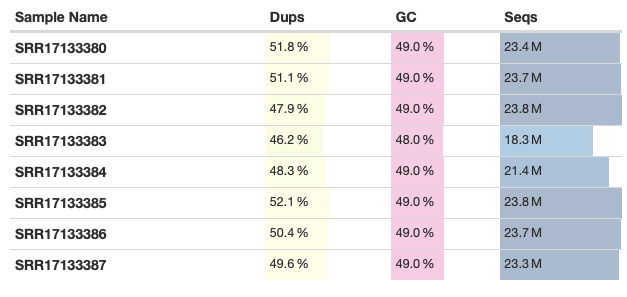

#### Per Sequence Quality Scores:

This plot shows the quality scores of individual bases across all reads at each position. The quality score indicates the probability of an incorrect base call.
- The x-axis represents the position in the read (from 5' to 3').
- The y-axis represents the quality score.
  
In the plot below, all positions maintain a quality score above 30, which is considered high. This indicates a low probability of sequencing errors, suggesting overall high-quality data.

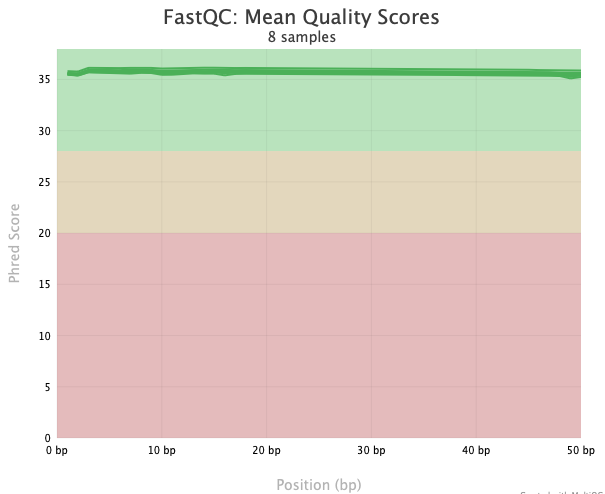


#### Per Sequence Quality:

This plot shows the distribution of average quality scores across all reads in a sequencing dataset.
- The x-axis represents the average quality score per read.
- The y-axis represents the number of reads with that average quality score.

In the plot below, all files show a single peak at **quality 35-36**, with no additional peaks. This suggests consistently high sequencing quality across the dataset and, therefore, indicates that no major quality issues are present.

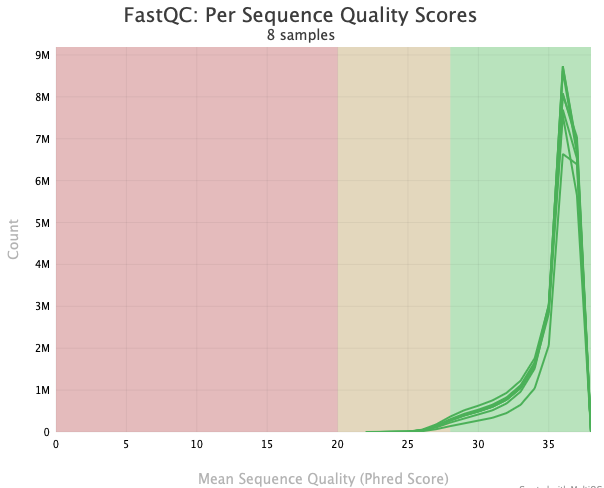


#### Per Sequence GC Content:

This plot shows the distribution of GC content per read in a file. Normal random libraries typically have a roughly normal distribution of GC content.

In the plot below, all files show distributions that are very similar to normal distributions, with the mean at 50%, as expected.

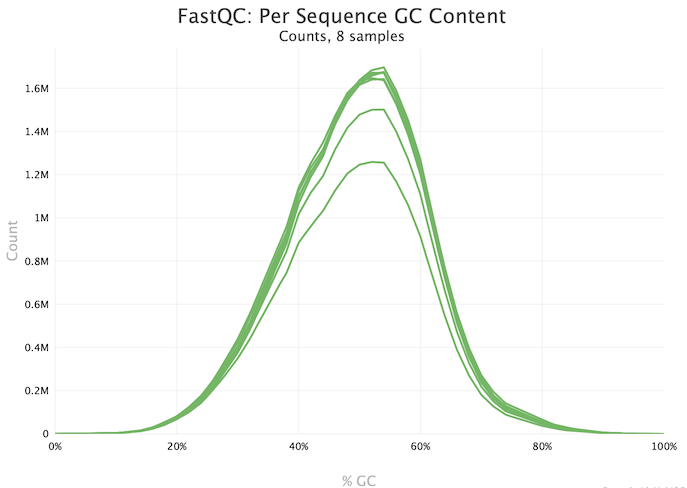


#### Per Base N Content:

This plot shows the percentage of base calls at each position for which an *N* was called, indicating an inability to determine the correct base.

In the plot below, no N calls were observed across all reads and positions in any file, confirming that the sequencing data contains no unidentified bases.

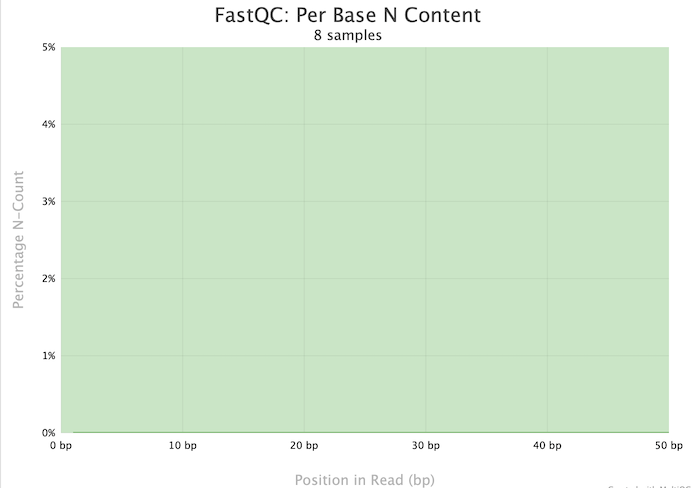


#### Sequence Duplication Levels:

This plot shows how many times each sequence appears in the dataset as a distribution.

In the plot below, some sequences appear many times; this is expected as we deal with bulk RNAseq and there is a large number of sequences in each file. The next test supports there is no over-representation.

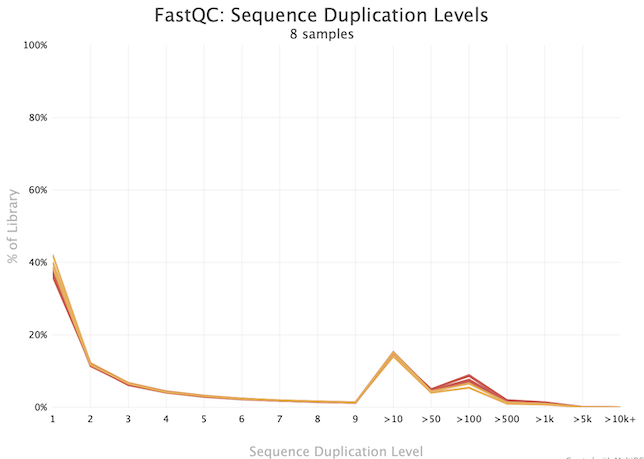


#### Overrepresented Sequences:

This segment shows lists of sequences that make up more than 1% of the total reads. The Presence of overrepresented sequences can suggest low library diversity or potential contamination.

As we can see, there are no overrepresented sequences found in these files
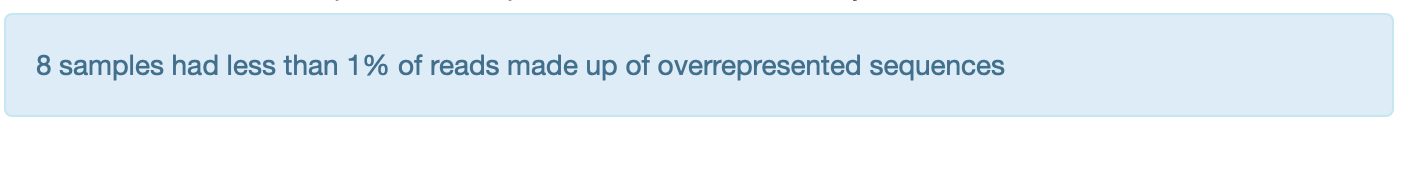


#### Adapter Content:

This plot shows the presence of common adapter sequences according to the read position.
As we can see, in some files some adapter sequences found in these files
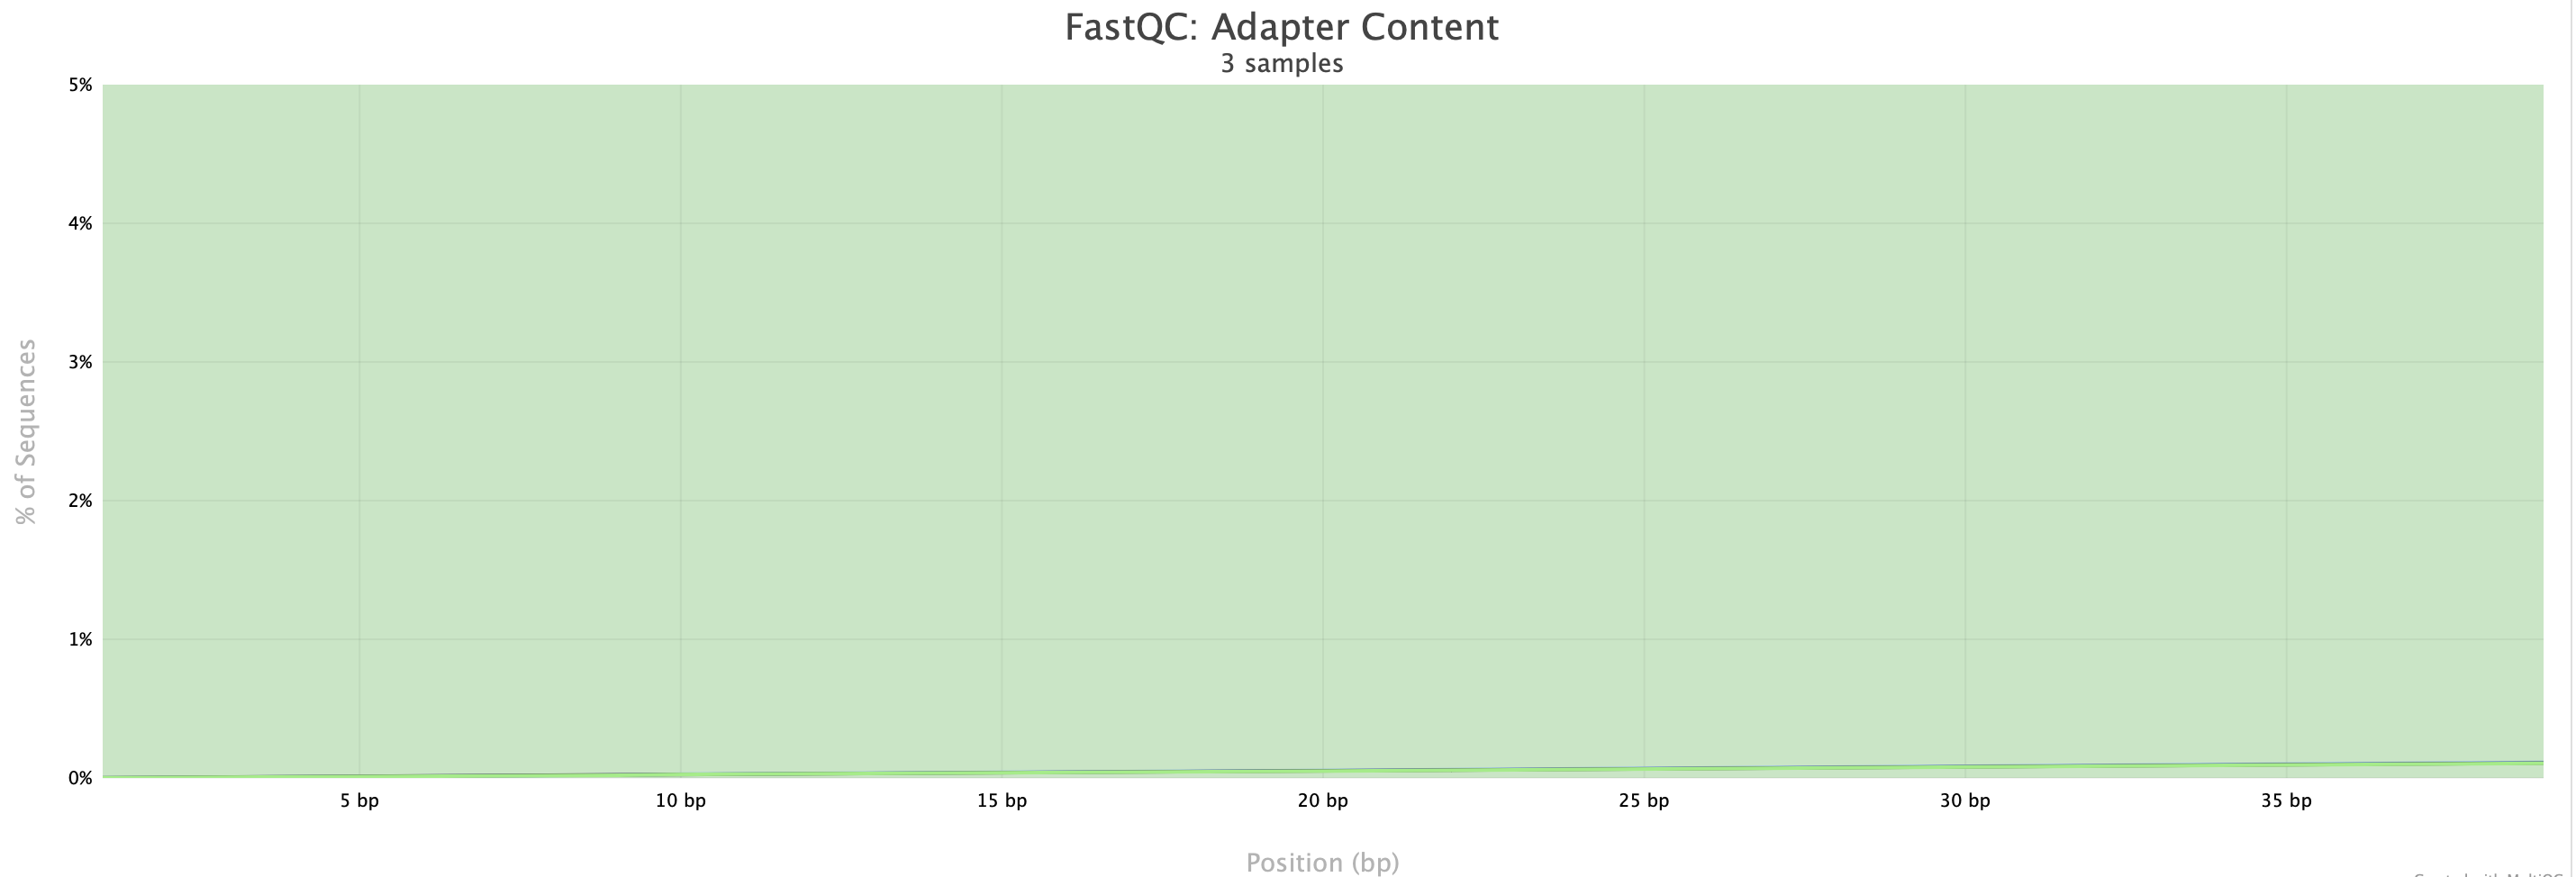


### 3. Trimming

In [ ]:
!mkdir -p SRP349257_fastq_trim  
# Running trimmomatic
!for file in SRP349257_fastq/*.fastq; do base=$(basename "$file" .fastq); trimmomatic SE -threads 8 "$file" SRP349257_fastq_trim/"${base}_trimmed.fastq" LEADING:30 TRAILING:30 SLIDINGWINDOW:4:30 MINLEN:36; done


TrimmomaticSE: Started with arguments:
 -threads 8 SRP349257_fastq/SRR17133380.fastq SRP349257_fastq_trim/SRR17133380_trimmed.fastq LEADING:30 TRAILING:30 SLIDINGWINDOW:4:30 MINLEN:36
Quality encoding detected as phred33
Input Reads: 23372262 Surviving: 18463159 (79.00%) Dropped: 4909103 (21.00%)
TrimmomaticSE: Completed successfully
TrimmomaticSE: Started with arguments:
 -threads 8 SRP349257_fastq/SRR17133381.fastq SRP349257_fastq_trim/SRR17133381_trimmed.fastq LEADING:30 TRAILING:30 SLIDINGWINDOW:4:30 MINLEN:36
Quality encoding detected as phred33
Input Reads: 23711155 Surviving: 18474624 (77.92%) Dropped: 5236531 (22.08%)
TrimmomaticSE: Completed successfully
TrimmomaticSE: Started with arguments:
 -threads 8 SRP349257_fastq/SRR17133382.fastq SRP349257_fastq_trim/SRR17133382_trimmed.fastq LEADING:30 TRAILING:30 SLIDINGWINDOW:4:30 MINLEN:36
Quality encoding detected as phred33
Input Reads: 23834934 Surviving: 18935809 (79.45%) Dropped: 4899125 (20.55%)
TrimmomaticSE: Completed succe

### QC analysis

In [ ]:
! mkdir SRP349257_trimmed_qc
! echo "file created, starting fastqc"
! fastqc SRP349257_fastq_trim/*.fastq -o SRP349257_trimmed_qc/
! echo "starting multiiqc"
! multiqc SRP349257_trimmed_qc/ -o SRP349257_trimmed_qc/

## Alignment and DGE

Similar to what we did in class and in the assignemnts, you will now run through the steps of mapping and conducting DGE. Include below an elaborate report of your analysis, include study desgin, example count and normalized count matrices, draw summary satistics and every other information you think is relevent to report your findings (if any)

Running `STAR` on a laptop or PC is almost impossible we will use one of the more recent pseudo alighners, ['kallisto`](https://pachterlab.github.io/kallisto/manual), which will allow us to quantify transcript level information in a more efficent manner.

1. Download the index files from kallisto's GitHub
```bash
wget https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz
tar -xf mouse_index_standard.tar.xz
```
2. Install and run `kallisto`
```bash
conda install -c bioconda -c conda-forge kallisto==0.50.1
kallisto quant -i index.idx -o output -t 16 sample.fastq 
```

In the `output` directory you should have `abundance.tsv`. View the file and make sure you understand it. Produce quantification to all your samples.
We now need to sum up transcript level counts to gene level counts before proceeding to `pyDESEQ`

In [ ]:
!pwd
!wget https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz
!tar -xf mouse_index_standard.tar.xz



We ran `kallisto quant` in single-end mode with an average sequence length of **50 bp** and a standard deviation of **0.000001**, since a value of **0** is invalid.  
For each FASTQ file, we created a corresponding subfolder to store its output.  


In [ ]:
!for srr_file in ./SRP349257_fastq_trim/*; do echo "$srr_file";  kallisto quant -i index.idx --single -l 50 -s 0.000001 -o output/$(basename "$srr_file" .fastq) -t 16 "$srr_file"; done



```python
import pandas as pd

# Load transcript to gene mapping file
t2g_file = 't2g.txt'
t2g_df = pd.read_csv(t2g_file, sep='\t', usecols=[0, 2], header=None, names=['transcript_id', 'gene_id'])

abundance_file = 'output/abundance.tsv'
abundance_df = pd.read_csv(abundance_file, sep='\t')

# Merge transcript abundance with gene mapping
merged_df = pd.merge(abundance_df, t2g_df, left_on='target_id', right_on='transcript_id', how='inner')

# Sum abundances at the gene level
gene_abundance_df = merged_df.groupby('gene_id')['tpm'].sum().reset_index()

# Save gene-level abundance to a new file
print(gene_abundance_df)
gene_abundance_df.to_csv('gene_abundance.csv', index=False)
```

Do you understand the code? Include `print` statments and rerun until you understnad what's going on fully

Do this operation to each of your sample's abundance file. Using python or a different tool merge all samples to a single file.

You should now be able to take the resulting `all_samples_gene_abundance.csv` and use it in `pyDeSeq2` as we did in class

## Gene Set Enrichment Analysis

Explain what GSEA is and what insights can we draw from it.

Execute a GSEA analysis using [pyGSEA](https://gseapy.readthedocs.io/en/latest/introduction.html) and summarize your results below.

## Notes

This excerise is meant to 'through' in the water and might prove challanging. Attempt to work in groups to overcome challanges. 

If you get stuck try to post an issue, but give as much background and explanation of your problem as possible so I could help

### Good luck!